# PSM for tree TRW (VS-Lite)

In this tutorial, we introduce the PSM for tree TRW (VS-Lite) in `p2k`.

In [1]:
%load_ext autoreload
%autoreload 2

import p2k
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

In [2]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = p2k.ProxyDatabase().from_df(df)

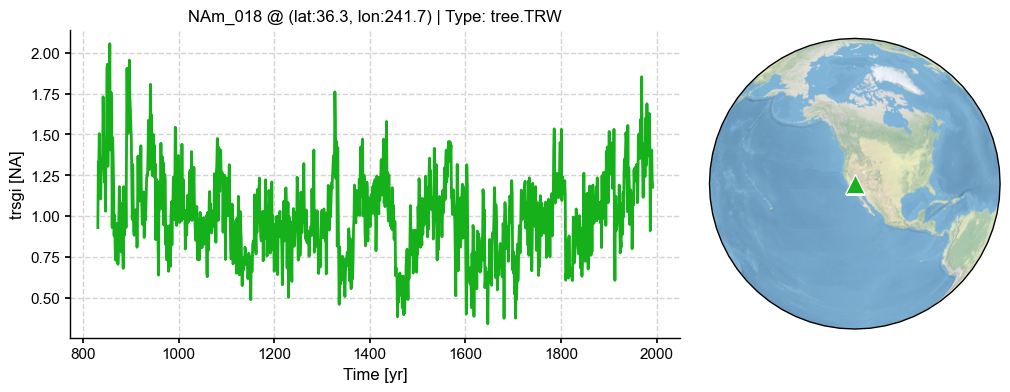

In [3]:
pobj = pdb.records['NAm_018']
fig, ax = pobj.plot()

### Model

In [4]:
dirpath = '/Volumes/ExtraDrive/Data/GCM_sims/icesm_last_millennium_historical'

model_tas = p2k.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = p2k.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [5]:
model_tas.da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
[191766528 values with dtype=float32]
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  Reference height temperature
    units:      K

### Instrumental observation

In [7]:
dirpath = '/Volumes/ExtraDrive/Data/Analyses/CRUTS'

obs_tas_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [8]:
obs_pr = obs_pr_ds.fields['pre'].rename('pr')
obs_tas = obs_tas_ds.fields['tmp'].rename('tas')

In [9]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 10 ms, sys: 611 µs, total: 10.6 ms
Wall time: 10.5 ms


In [10]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [11]:
obs_pr_new = obs_pr.wrap_lon()

In [12]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [13]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

ProxyRecord.clim deleted for NAm_018.
ProxyRecord.clim["model_tas"] created.
ProxyRecord.clim["model_pr"] created.
ProxyRecord.clim["obs_tas"] created.
ProxyRecord.clim["obs_pr"] created.
CPU times: user 93.6 ms, sys: 3.82 ms, total: 97.5 ms
Wall time: 101 ms


In [14]:
pobj.clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ 0.4,  0.1,  0.5, ..., 10.3,  2.9,  0.9], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [26]:
mdl = p2k.psm.VSLite(pobj)

In [27]:
%%time

mdl.calibrate()
print(mdl.calib_details)

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0086   1.0038   1.0078   1.0214
{'T1': 5.098148090326561, 'T2': 16.754153916334428, 'M1': 0.032140920795951364, 'M2': 0.2913163851562237}
CPU times: user 38.2 ms, sys: 29.9 ms, total: 68.1 ms
Wall time: 32.3 s


In [28]:
%%time
pp = mdl.forward()

CPU times: user 491 ms, sys: 8.91 ms, total: 500 ms
Wall time: 502 ms


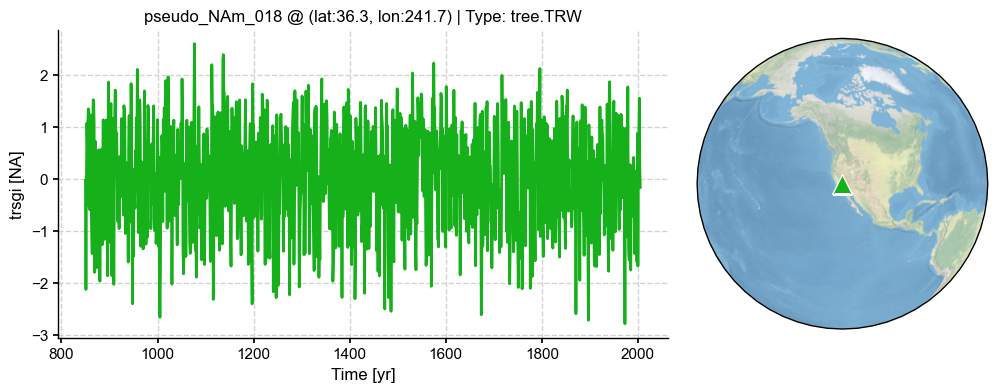

In [29]:
fig, ax = pp.plot()